Mounted at /content/drive
Initial v:  Parameter containing:
tensor([1.8645], requires_grad=True)
Epoch 1, L2相对误差: 1.2382269797623864, v: 1.8642095136303796
  Interior loss: 0.031442
  Data loss: 0.009514
  Initial loss: 0.011948
  Up boundary loss: 0.010251
  Down boundary loss: 0.002615
  Left boundary loss: 0.016440
  Right boundary loss: 0.006123
  loss: 1.224064
Epoch 1000, L2相对误差: 0.41810855771039723, v: 1.5391208601564736
  Interior loss: 0.002698
  Data loss: 0.001079
  Initial loss: 0.003214
  Up boundary loss: 0.000112
  Down boundary loss: 0.000415
  Left boundary loss: 0.000341
  Right boundary loss: 0.000095
  loss: 0.088659
Epoch 2000, L2相对误差: 0.32785538194589453, v: 1.4579622011887172
  Interior loss: 0.002177
  Data loss: 0.000796
  Initial loss: 0.001620
  Up boundary loss: 0.000279
  Down boundary loss: 0.000073
  Left boundary loss: 0.000108
  Right boundary loss: 0.000132
  loss: 0.057979
Epoch 3000, L2相对误差: 0.26504964105547185, v: 1.5605594112331083
  Interior loss:

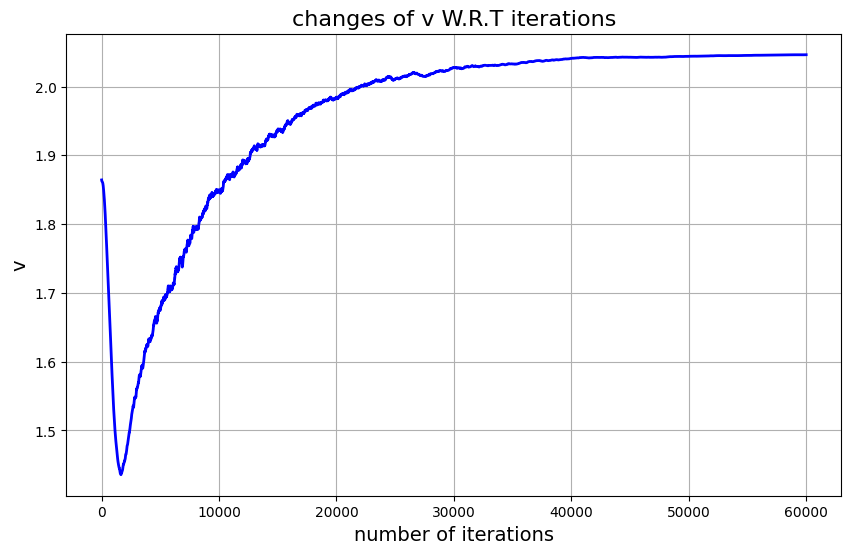

In [ ]:
#dxa_data
from google.colab import drive
drive.mount('/content/drive')
import torch
import numpy as np
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

sin = torch.sin
cos = torch.cos
exp = torch.exp
pi = torch.pi
torch.set_default_dtype(torch.float64)


EPSILON = 0.01
EPSILON = 0.1          # 噪声乘数 ε
EPSILON = 0.2

SIGMA   = 0.01
SIGMA   = 0.1          # 噪声标准差 σ
SIGMA   = 0.2

DATA_LOSS_WEIGHT = 50  # 数据项权重，调大可放大噪声影响
epochs = 60000  # 训练代数
h = 100  # 测试点网格密度
N = 2000  # 内点配置点数
N1 = 100  # 边界点配置点数
N2 = 200  # 数据点

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)

setup_seed(123456)


def add_noise(z, epsilon=1.0, sigma=0.1):
    noise = epsilon * np.random.normal(loc=0.0, scale=sigma, size=z.shape)
    return z + noise

def gen_testdata(epsilon=0.0, sigma=0.0):
    data = np.load("/content/drive/MyDrive/dxa_data_3_2.1.npz")


    t, x, y, usol = data["t"], data["x"], data["y"], data["u_sol"]
    xx, yy, tt = np.meshgrid(x, y, t)
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    z = usol.flatten()[:, None]
    z_noisy = add_noise(z, epsilon, sigma)
    return X, z_noisy

def l2_relative_error(z_true, z_pred):
    return np.linalg.norm(z_true - z_pred) / np.linalg.norm(z_true)

# Domain and Sampling (修改为3D采样)
def interior(n=N):
    # 内点采样 x∈[-3,3], y∈[-3,3], t∈[0,1]
    x = torch.rand(n, 1)*6 - 3  # [-3,3]
    y = torch.rand(n, 1)*6 - 3  # [-3,3]
    t = torch.rand(n, 1)        # [0,1]
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def ini(n=N1):
    # 初始条件 t=0
    x = torch.rand(n, 1)*6 - 3
    y = torch.rand(n, 1)*6 - 3
    t = torch.zeros_like(x)
    cond = torch.where(x**2+y**2<0.25, torch.full_like(x,0.5), torch.zeros_like(x))  # 示例条件
    return x.requires_grad_(True), y.requires_grad_(True), t.requires_grad_(True), cond

def left(n=N1):
    # 边界 u(-3,y,t)=0
    t = torch.rand(n, 1)
    x = -3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def right(n=N1):
    # 边界 u(3,y,t)=0
    t = torch.rand(n, 1)
    x = 3 * torch.ones_like(t)
    y = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def up(n=N1):
    # 边界 u(x,3,t)=0
    t = torch.rand(n, 1)
    y = 3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True), y.requires_grad_(True),t.requires_grad_(True), cond

def down(n=N1):
    # 边界 u(x,-3,t)=0
    t = torch.rand(n, 1)
    y = -3 * torch.ones_like(t)
    x = torch.rand(n, 1)*6 - 3
    cond = torch.zeros_like(t)
    return x.requires_grad_(True),y.requires_grad_(True), t.requires_grad_(True), cond

def data_interior(n=N2):
    X, Y = gen_testdata(EPSILON, SIGMA)     # 全局噪声参数
    ids = np.random.randint(X.shape[0], size=n)
    xy_t = torch.from_numpy(X[ids]).requires_grad_(True)
    cond = torch.from_numpy(Y[ids])
    return xy_t, cond

# Neural Network (输入维度改为3)
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 64),  # 输入x,y,t
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )


    def forward(self, x):
        features = self.net(x)
        u_val = torch.abs(features)
        #u_val = torch.clamp(features, min=0, max=5.0)
        #u_val = features

        #print("u_val mean:", u_val.mean().item())

        return u_val


# Loss functions
loss = torch.nn.MSELoss()


def gradients(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 create_graph=True,
                                 only_inputs=True)[0]
    else:
        return gradients(gradients(u, x), x, order=order-1)

v = torch.nn.Parameter(torch.randn(1), requires_grad=True)
#v = torch.nn.Parameter(torch.tensor([1.9]), requires_grad=True) ##33
print('Initial v: ', v)

def l_interior(u):
    x, y, t, cond = interior()
    inputs = torch.cat([x, y, t], dim=1)
    u_val = u(inputs)  # 原始网络输出

    # 动态计算缩放因子（仅用于PDE部分）
   # with torch.no_grad():
        #current_scale = torch.mean(u_val) + 1e-6  # 防止除零
        #print(f"Current scale: {current_scale.item():.4f}")  # 监控缩放因子

    # 计算缩放后的u'及其导数
    u_prime = u_val * 1
    u_t = gradients(u_prime, t, 1)
    u_x = gradients(u_prime, x, 1)
    u_y = gradients(u_prime, y, 1)
    u_xx = gradients(u_prime, x, 2)
    u_yy = gradients(u_prime, y, 2)

    # 原始PDE: u_t - 2*(u_x^2 + u_y^2) - 2*u*(u_xx + u_yy) - 2*u = 0
    # 替换为 u' 的PDE形式：
    #residual = u_t - (1/100)*2*(u_x**2+u_y**2)-2*u_prime*(1/100)*(u_xx + u_yy) - (v)*u_prime
    #residual = u_t - 1*(6*u_prime*(u_x**2+u_y**2)*((1/100)**2)-3*(u_prime**2)*(u_xx + u_yy)*((1/100)**2)) - v*u_prime
    residual = u_t - 6*u_prime*(u_x**2+u_y**2)-3*(u_prime**2)*(u_xx + u_yy) - v*u_prime
    #print("u_val均值:", u_prime.mean().item())
    return loss(residual, cond)

def l_ini(u):
    x, y, t, cond = ini()
    u_val = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_left(u):
    # 边界条件损失
    x, y, t, cond = left()
    u_val = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_right(u):
    # 边界条件损失
    x, y, t, cond = right()
    u_val = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_up(u):
    # 边界条件损失
    x, y, t, cond = up()
    u_val = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_down(u):
    # 边界条件损失
    x, y, t, cond = down()
    u_val = u(torch.cat([x, y, t], dim=1))
    return loss(u_val, cond)

def l_data(u):
    xyt, cond = data_interior()
    u_val = u(xyt)
    return loss(u_val, cond)



# Training
#u = MLP()
#opt = torch.optim.Adam(u.parameters(), lr=1e-3)
u = MLP()
opt = torch.optim.RAdam(list(u.parameters()) + [v], lr=1e-3)

scheduler = StepLR(opt, step_size=1000, gamma=0.9)  # 对所有参数应用调度
#opt1 = torch.optim.Adam([v], lr=1e-3)  # v 的学习率更大


#scheduler = StepLR(opt1, step_size=10000, gamma=0.5)

# 记录训练过程
L2_error = []
v_values = []
iterations = []

# 获取测试数据
xy_t, u_real = gen_testdata()
xy_t = torch.from_numpy(xy_t)

for i in range(epochs):
    opt.zero_grad()
    #opt1.zero_grad()
    l_i = l_interior(u)
    l_d = l_data(u)
    l_initial = l_ini(u)
    l_u = l_up(u)
    l_dn = l_down(u)
    l_l = l_left(u)
    l_r = l_right(u)
    #loss_v_penalty = loss(v, v_target * torch.ones_like(v))

    # 计算各项损失
    l = 10*l_i + l_initial + l_dn + l_u + l_l + l_r + 60*l_data(u) #+ 0.1*loss_v_penalty
    l.backward()
    #print("v的梯度:", v.grad.mean().item())   # 检查梯度是否与u_val同量级
    torch.nn.utils.clip_grad_norm_(u.parameters(), 0.1)

    opt.step()
    #opt1.step()
    scheduler.step()
    v.data.clamp_(min=1e-6)#强行为正

    # 记录参数
    v_values.append(v.item())
    iterations.append(i+1)

    if (i+1) % 1000 == 0 or i == 0:
        u_pred = u(xy_t)
        error = l2_relative_error(u_real, u_pred.detach().numpy())
        L2_error.append(error)
        print(f"Epoch {i+1}, L2相对误差: {error}, v: {v.item()}")
        print(f"  Interior loss: {l_i.item():.6f}")
        print(f"  Data loss: {l_d.item():.6f}")
        print(f"  Initial loss: {l_initial.item():.6f}")
        print(f"  Up boundary loss: {l_u.item():.6f}")
        print(f"  Down boundary loss: {l_dn.item():.6f}")
        print(f"  Left boundary loss: {l_l.item():.6f}")
        print(f"  Right boundary loss: {l_r.item():.6f}")
        print(f"  loss: {l.item():.6f}")


print('Final v: ', v)
plt.figure(figsize=(10, 6))
plt.plot(iterations, v_values, 'b-', linewidth=2)
plt.xlabel('number of iterations', fontsize=14)
plt.ylabel('v', fontsize=14)
plt.title('changes of v W.R.T iterations', fontsize=16)
plt.grid(True)
plt.show()
